# Galaxies Morphology Classification Using CNN

Using the Galaxy-Zoo dataset available on kaggle: https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/data,
we will exploit a Convolutional Neural Network to train a model for galaxy morphology classification.


In [3]:
#Importing libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, random, shutil
import tensorflow as tf
import seaborn
from tensorflow import keras
from tensorflow.keras import preprocessing, layers
from tensorflow.keras.callbacks import EarlyStopping
from keras_preprocessing import image



## Introduction and data interpretation.


The dataset has been crowdsource-labeld and the data we are working on are labeled following that decision tree:

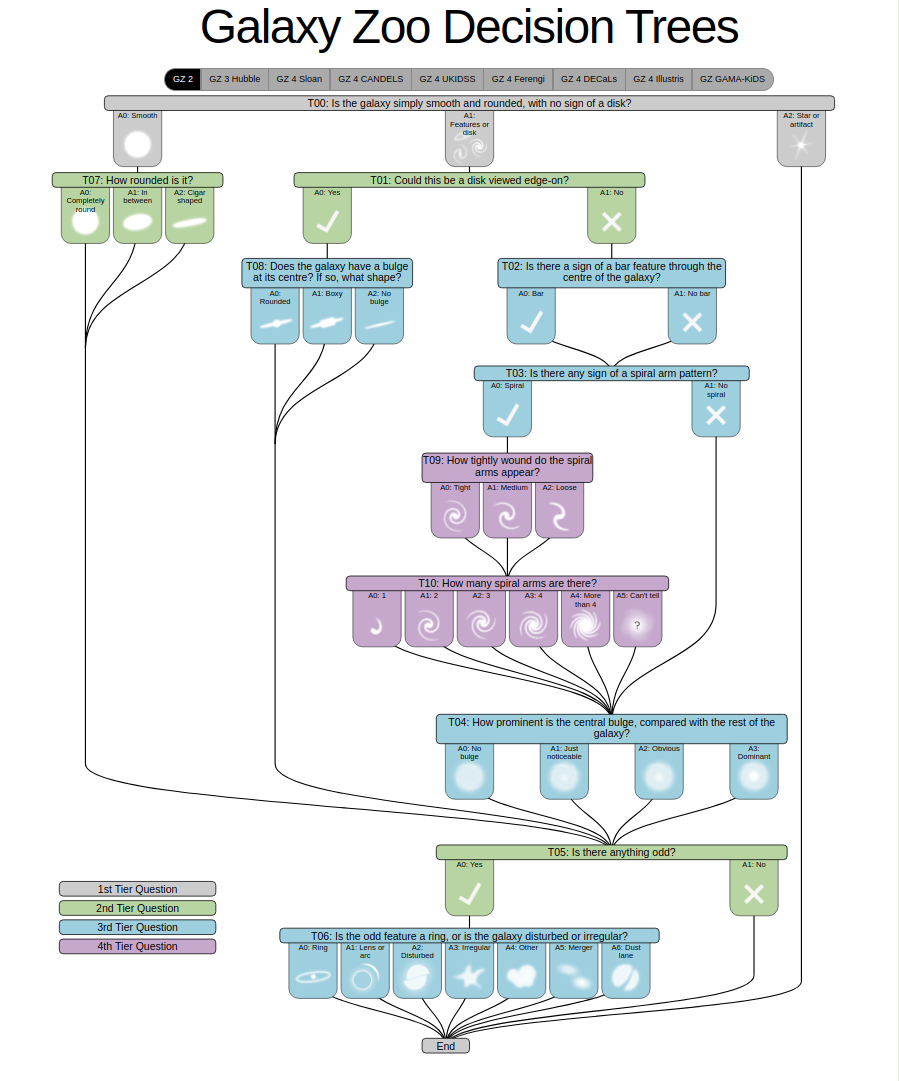






We will define 3 classes corresponding to galaxy morphologies sub-setting the decision tree:


Elliptical: Q1.1 > 0.8 and Q7.1 > 0.6 


Lenticular: Q1.1 > 0.8 and Q7.2 > 0.6  


Cigar-shaped: Q1.1 > 0.8 and Q7.3 > 0.6 and Q8.3 < 0.2 (A Cigar shape is not so far away from a disk with no bulge.)




In [4]:
#Set the base paths
base_path = r'/home/ale/Scrivania/hubble_search_project/galaxy-zoo-the-galaxy-challenge'
training_solutions = os.path.join(base_path, 'training_solutions_rev1.csv')
training_images    = os.path.join(base_path, 'images_training_rev1')

Create the dataset and updating the columns names to match our notation.

In [5]:

df = pd.read_csv(training_solutions)
cols = df.columns
new = list(map(lambda s: s.replace('Class','Q'), cols))
df.columns = new
df.head()

,GalaxyID,Q1.1,Q1.2,Q1.3,Q2.1,Q2.2,Q3.1,Q3.2,Q4.1,Q4.2,...,Q9.3,Q10.1,Q10.2,Q10.3,Q11.1,Q11.2,Q11.3,Q11.4,Q11.5,Q11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


Create the class-substet of the database and visualizing the lenghts:

In [29]:
ellipticals = df[(df['Q1.1']>0.7) & (df['Q7.1']>0.4)]['GalaxyID'].tolist()

lenticulars = df[(df['Q1.1']>0.7) & (df['Q7.2']>0.4)]['GalaxyID'].tolist()

spirals = df[(df['Q1.2']>0.7) & (df['Q2.1']>0.4)]['GalaxyID'].tolist()

print('Total number of elliptical examples: ',  len(ellipticals))
print('Total number of lenticular examples: ',  len(lenticulars))
print('Total number of spiral examples: ',  len(spirals))



Total number of elliptical examples:  7311
Total number of lenticular examples:  6625
Total number of spiral examples:  4635


Defining a function that will randomly select the training and validation images for each class and create subfolders:


In [33]:
def _proc_images(src, dst, label, arr, percent):
    train_dir = os.path.join(dst, 'train')
    val_dir = os.path.join(dst, 'validation')
    
    train_dest = os.path.join(train_dir, label)
    val_dest   = os.path.join(val_dir, label)
    
    if not os.path.exists(train_dest):
        os.makedirs(train_dest)

    if not os.path.exists(val_dest):
        os.makedirs(val_dest)
    
    random.shuffle(arr)
    
    idx = int(len(arr)*percent)
    for i in arr[0:idx]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(train_dest, str(i)+'.jpg'))
    for i in arr[idx:]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(val_dest, str(i)+'.jpg'))
    
    print(label, 'done!')
    
    my_data = os.path.join(base_path, 'data')

In [34]:
_proc_images(training_images, my_data, 'elliptical', ellipticals, 0.80)
_proc_images(training_images, my_data, 'lenticular', lenticulars, 0.80)
_proc_images(training_images, my_data, 'spiral', spirals, 0.80)


print('Elliptical:', len(os.listdir(os.path.join(my_data, 'train', 'elliptical'))))
print('Total train lenticular:', len(os.listdir(os.path.join(my_data, 'train', 'lenticular'))))
print('Total train spiral:', len(os.listdir(os.path.join(my_data, 'train', 'spiral'))))


print('Total validation elliptical:', len(os.listdir(os.path.join(my_data, 'validation', 'elliptical'))))
print('Total validation lenticular:', len(os.listdir(os.path.join(my_data, 'validation', 'lenticular'))))
print('Total validation spiral:', len(os.listdir(os.path.join(my_data, 'validation', 'spiral'))))


elliptical done!
lenticular done!
spiral done!
Elliptical: 7026
Total train lenticular: 6354
Total train spiral: 4437
Total validation elliptical: 2641
Total validation lenticular: 2379
Total validation spiral: 1656


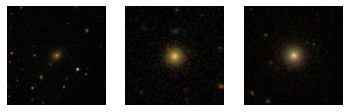

In [35]:
# elliptical class
for num, file in enumerate(os.listdir(os.path.join(my_data, 'train', 'elliptical'))[0:3]):
    img = image.load_img(os.path.join(my_data, 'train', 'elliptical', file) , target_size=(150, 150))
    plt.subplot(1, 3, num+1)
    plt.axis('off')
    plt.imshow(img)

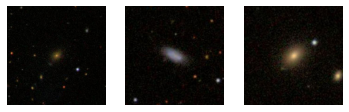

In [36]:
# lenticular class
for num, file in enumerate(os.listdir(os.path.join(my_data, 'train', 'lenticular'))[0:3]):
    img = image.load_img(os.path.join(my_data, 'train', 'lenticular', file) , target_size=(150, 150))
    plt.subplot(1, 3, num+1)
    plt.axis('off')
    plt.imshow(img)

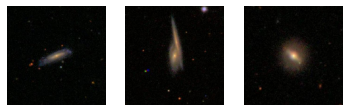

In [37]:
# spiral class
for num, file in enumerate(os.listdir(os.path.join(my_data, 'train', 'spiral'))[0:3]):
    img = image.load_img(os.path.join(my_data, 'train', 'spiral', file) , target_size=(150, 150))
    plt.subplot(1, 3, num+1)
    plt.axis('off')
    plt.imshow(img)

In [ ]:
train_dir = '/home/ale/Scrivania/hubble_search_project/galaxy-zoo-the-galaxy-challenge/data/train'
validation_dir = '/home/ale/Scrivania/hubble_search_project/galaxy-zoo-the-galaxy-challenge/data/validation




In [ ]:
total_train = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_train += len(os.listdir(os.path.join(train_dir, c)))
print('Total train:', total_train)

total_validation = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_validation += len(os.listdir(os.path.join(validation_dir, c)))
print('Total validation:', total_validation)

Data Augmentation. 

Given that from from ellipticals to cigars the galaxies shapes got a decreasing number of symmetry axis, we will preprocess the images with random flips and random rotations. 

In [17]:
BS=32

In [18]:

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=25,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.2)
validation_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(180,180),
                                                    batch_size=BS,
                                                    shuffle=True,
                                                    class_mode='categorical')
validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                         target_size=(180,180),
                                                         batch_size=BS,
                                                         shuffle=True,
                                                         class_mode='categorical')

Found 14856 images belonging to 3 classes.
Found 3715 images belonging to 3 classes.


In [39]:
#Net architecture

model = tf.keras.models.Sequential([
    # first convolution layer, input is an 150x150 image x3 colors
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',input_shape=(180, 180, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # second convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # third convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # fourth convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # flatten the image pixels
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron fully connected hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 86, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 84, 84, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 128)       7

In [21]:
from tensorflow.keras import losses
LOSS= tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0, reduction="auto", name="categorical_crossentropy")
model.compile(loss=LOSS,
              optimizer='adam',
              metrics=['accuracy'])
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=10, restore_best_weights=False)

In [22]:
EPOCHS = 100

history = model.fit(train_generator,
                    epochs=EPOCHS,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator)//BS,
                    verbose=1)

Epoch 1/100
464/464 [==============================] - 974s 2s/step - loss: 0.9692 - accuracy: 0.4716 - val_loss: 0.6885 - val_accuracy: 0.6667
Epoch 2/100
464/464 [==============================] - 1045s 2s/step - loss: 0.7038 - accuracy: 0.6108 - val_loss: 0.7818 - val_accuracy: 0.5104
Epoch 3/100
464/464 [==============================] - 977s 2s/step - loss: 0.6055 - accuracy: 0.6840 - val_loss: 0.4986 - val_accuracy: 0.7917
Epoch 4/100
464/464 [==============================] - 972s 2s/step - loss: 0.5129 - accuracy: 0.7585 - val_loss: 0.4135 - val_accuracy: 0.8021
Epoch 5/100
464/464 [==============================] - 980s 2s/step - loss: 0.4569 - accuracy: 0.7942 - val_loss: 0.4207 - val_accuracy: 0.7917
Epoch 6/100
464/464 [==============================] - 986s 2s/step - loss: 0.4525 - accuracy: 0.7947 - val_loss: 0.3856 - val_accuracy: 0.8125
Epoch 7/100
464/464 [==============================] - 970s 2s/step - loss: 0.4277 - accuracy: 0.8095 - val_loss: 0.3889 - val_accuracy

464/464 [==============================] - 1046s 2s/step - loss: 0.3124 - accuracy: 0.8665 - val_loss: 0.4542 - val_accuracy: 0.8021
Epoch 58/100
464/464 [==============================] - 1046s 2s/step - loss: 0.3148 - accuracy: 0.8617 - val_loss: 0.2817 - val_accuracy: 0.8750
Epoch 59/100
464/464 [==============================] - 1046s 2s/step - loss: 0.3345 - accuracy: 0.8544 - val_loss: 0.2612 - val_accuracy: 0.8750
Epoch 60/100
464/464 [==============================] - 1046s 2s/step - loss: 0.3238 - accuracy: 0.8622 - val_loss: 0.3384 - val_accuracy: 0.8438
Epoch 61/100
464/464 [==============================] - 1046s 2s/step - loss: 0.3154 - accuracy: 0.8638 - val_loss: 0.3563 - val_accuracy: 0.8542
Epoch 62/100
464/464 [==============================] - 1046s 2s/step - loss: 0.3216 - accuracy: 0.8600 - val_loss: 0.4516 - val_accuracy: 0.7500
Epoch 63/100
464/464 [==============================] - 1044s 2s/step - loss: 0.3168 - accuracy: 0.8653 - val_loss: 0.3905 - val_accuracy

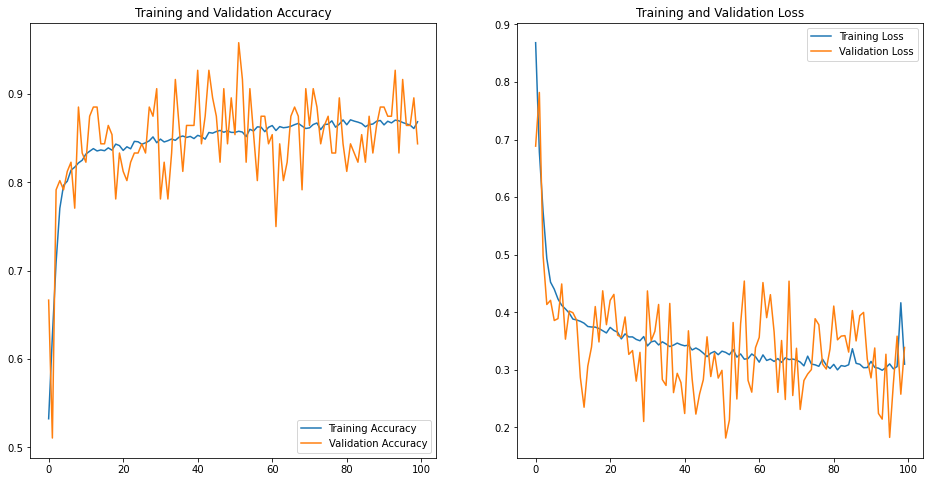

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # range for the number of epochs

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./plots-v2.png')
plt.show()

In [43]:
from tensorflow.keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
